This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Computing cartesian and geographical coordinates for polar data

In [1]:
import numpy as np
import wradlib as wrl
import xradar as xd
import warnings

warnings.filterwarnings("ignore")

## Read the data

Here, we use an OPERA hdf5 dataset.

In [2]:
filename = "hdf5/20130429043000.rad.bewid.pvol.dbzh.scan1.hdf"
filename = wrl.util.get_wradlib_data_file(filename)
pvol = xd.io.open_odim_datatree(filename)
display(pvol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2013-04-29T04:30:00Z'
│       time_coverage_end    <U20 '2013-04-29T04:31:39Z'
│       longitude            float64 5.506
│       altitude             float64 592.0
│       latitude             float64 49.91
│   Attributes:
│       Conventions:      ODIM_H5/V2_1
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:00.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:20.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:40.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:31:00.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│         

## Retrieve azimuthal equidistant coordinates and projection

In [3]:
for key in list(pvol.children):
    if "sweep" in key:
        pvol[key].ds = pvol[key].ds.wrl.georef.georeference()

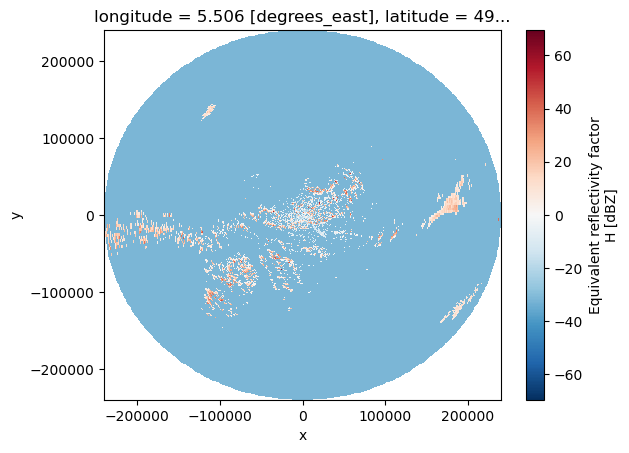

In [4]:
pvol["sweep_0"].ds.DBZH.plot(x="x", y="y")

## Retrieve geographic coordinates (longitude and latitude)

### Using crs-keyword argument.

In [5]:
for key in list(pvol.children):
    if "sweep" in key:
        pvol[key].ds = pvol[key].ds.wrl.georef.georeference(
            crs=wrl.georef.get_default_projection()
        )

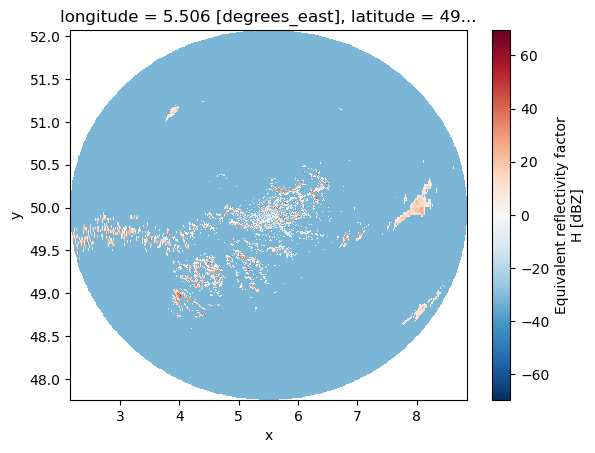

In [6]:
ds1 = pvol["sweep_0"].ds.wrl.georef.georeference(
    crs=wrl.georef.get_default_projection()
)
ds1.DBZH.plot(x="x", y="y")

### Using reproject

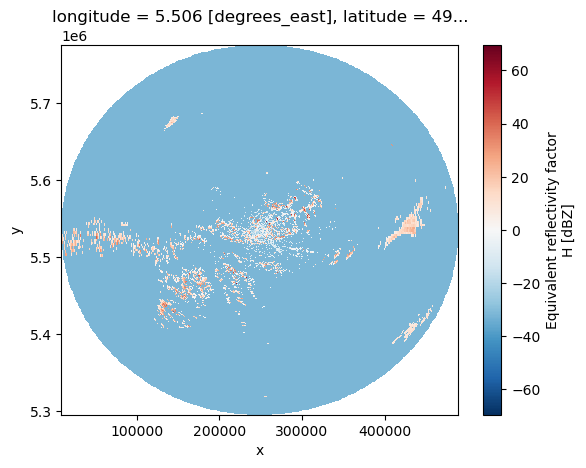

In [7]:
ds2 = pvol["sweep_0"].ds.wrl.georef.reproject(
    trg_crs=wrl.georef.epsg_to_osr(32632),
)
ds2.DBZH.plot(x="x", y="y")